## NLP Disaster Tweets

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3090


## EDA

   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1

Number of null entities in each column:
id        0
text      0
target    0
dtype: int64


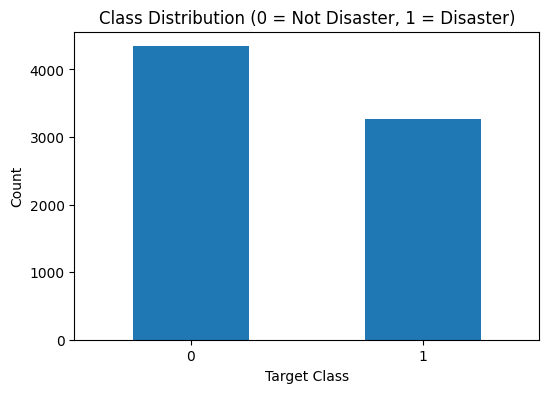

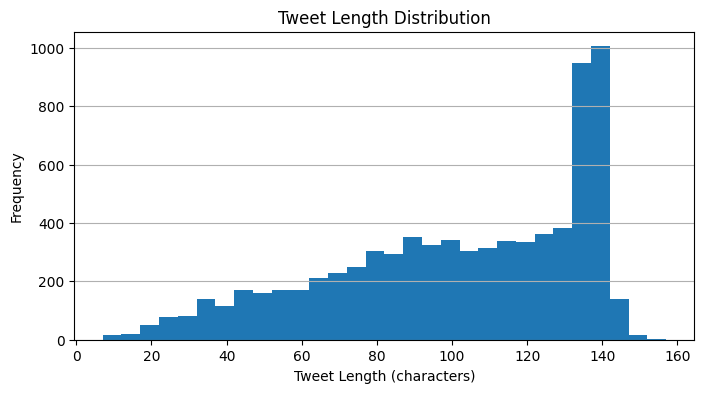

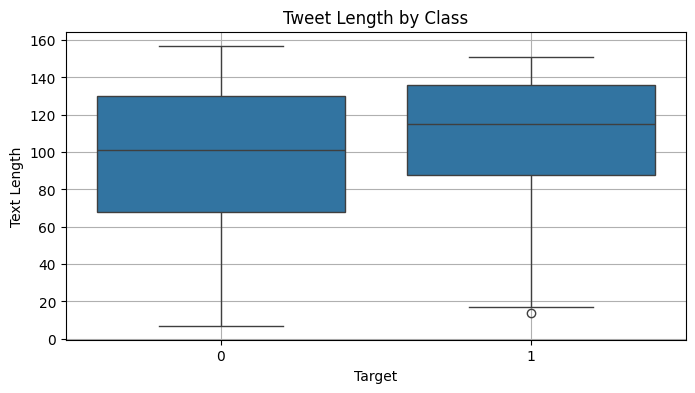

In [2]:
train_df = pd.read_csv('data/train.csv')
train_df = train_df.drop(columns=['keyword', 'location'])

print(train_df.head())

print(f'\nNumber of null entities in each column:\n{train_df.isnull().sum()}')

class_counts = train_df['target'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar')
plt.title('Class Distribution (0 = Not Disaster, 1 = Disaster)')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

train_df['text_length'] = train_df['text'].apply(len)

train_df['text_length'].hist(bins=30, figsize=(8, 4))
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')
plt.grid(axis='x')
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x='target', y='text_length', data=train_df)
plt.title('Tweet Length by Class')
plt.xlabel('Target')
plt.ylabel('Text Length')
plt.grid(True)
plt.show()


## Preprocessing/Cleaning

In [3]:
import re

def clean_tweet(text):
    # Lowercase
    text = text.lower()
    # Replace URLs with a token
    text = re.sub(r'http\S+|www\S+|https\S+', '<URL>', text)
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    # Strip '#' from hashtags but keep the word
    text = re.sub(r'#', '', text)
    # Remove HTML entities
    text = re.sub(r'&\w+;', '', text)
    # Remove punctuation (except for <URL>)
    text = re.sub(r'[^\w\s<>]', '', text)
    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

train_df['clean_text'] = train_df['text'].apply(clean_tweet)

## Preprocessing/Tokenization

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('punkt')
nltk.download('punkt_tab')

def tokens_to_ids(tokens, vocab):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

train_df['tokens'] = train_df['clean_text'].apply(word_tokenize)

token_counts = Counter(token for tokens in train_df['tokens'] for token in tokens)

special_tokens = ['<PAD>', '<UNK>']
vocab = {token: idx for idx, token in enumerate(special_tokens)}

min_frq = 2
for token, count in token_counts.items():
    if count >= min_frq and token not in vocab:
        vocab[token] = len(vocab)

for i, token in enumerate(special_tokens):
    vocab[token] = i

train_df['input_ids'] = train_df['tokens'].apply(lambda tokens: tokens_to_ids(tokens, vocab))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Build Trainer Dataset

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

class TweetDataset(Dataset):
    def __init__(self, df):
        self.inputs = df['padded_input_ids'].tolist()
        self.labels = df['target'].tolist()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.inputs[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

def pad_sequence(seq, max_len=160, pad_value=0):
    if len(seq) < max_len:
        return seq + [pad_value] * (max_len - len(seq))
    else:
        return seq[:max_len]
    
train_df['padded_input_ids'] = train_df['input_ids'].apply(lambda x: pad_sequence(x, max_len=160, pad_value=vocab['<PAD>']))

training_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['target'], random_state=42)

train_dataset = TweetDataset(training_df)
val_dataset = TweetDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


## Model Building
`Input IDs → Embedding → Bidirectional LSTM → Dropout → Linear → Sigmoid`

In [6]:
import torch.nn as nn

class DisasterTweetLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128, num_layers=1, bidirectional=True, dropout=0.3, pad_idx=0):
        super(DisasterTweetLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids):
        embedded = self.dropout(self.embedding(input_ids))
        lstm_out, (hidden, cell) = self.lstm(embedded)

        if self.lstm.bidirectional:
            final_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            final_hidden = hidden[-1]

        output = self.fc(self.dropout(final_hidden))
        return output.view(-1)
    
vocab_size = len(vocab)
pad_idx = vocab['<PAD>']

model = DisasterTweetLSTM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    num_layers=1,
    bidirectional=True,
    dropout=0.5,
    pad_idx=pad_idx
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


DisasterTweetLSTM(
  (embedding): Embedding(6584, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Model Training

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import torch.nn.functional as F

def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler=None, n_epochs=5, log_dir='runs/disaster_lstm'):
    writer = SummaryWriter(log_dir=log_dir)
    global_step = 0

    best_val_acc = 0
    patience = 10
    epochs_no_improve = 0


    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        train_acc = 0

        print(f'\nEpoch {epoch+1}/{n_epochs}')
        train_iter = tqdm(train_loader, desc='Training', leave=False)

        for batch in train_iter:
            input_ids = batch['input_ids'].to(torch.device('cuda'))
            labels = batch['label'].to(torch.device('cuda'))

            optimizer.zero_grad()
            preds = model(input_ids)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            acc = binary_accuracy(preds, labels)
            train_loss += loss.item()
            train_acc += acc.item()
            global_step += 1

            train_iter.set_postfix(loss=loss.item(), acc=acc.item())

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            val_iter = tqdm(val_loader, desc='Validation', leave=False)
            for batch in val_iter:
                input_ids = batch['input_ids'].to(torch.device('cuda'))
                labels = batch['label'].to(torch.device('cuda'))

                preds = model(input_ids)
                loss = criterion(preds, labels)
                acc = binary_accuracy(preds, labels)

                val_loss += loss.item()
                val_acc += acc.item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)

        # Log to TensorBoard
        writer.add_scalar('Loss/train', avg_train_loss, epoch)
        writer.add_scalar('Loss/val', avg_val_loss, epoch)
        writer.add_scalar('Accuracy/train', avg_train_acc, epoch)
        writer.add_scalar('Accuracy/val', avg_val_acc, epoch)
        writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch)

        if scheduler is not None:
            scheduler.step()

        # Epoch summary
        print(f'[Epoch {epoch+1}]\n'
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}\n'
              f'Val Loss:   {avg_val_loss:.4f}, Val Acc:   {avg_val_acc:.4f}')
        
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            torch.save(model.state_dict(), 'best_model.pt')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Stopping early.')
                break

    writer.close()

def binary_accuracy(preds, y):
    probs = torch.sigmoid(preds)
    rounded = torch.round(probs)
    correct = (rounded == y).float()
    
    return correct.sum() / len(correct)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)
criterion = nn.BCEWithLogitsLoss()

log_dir = 'runs/'

train_model(model, train_loader, val_loader, optimizer, criterion, scheduler=scheduler, n_epochs=30, log_dir=log_dir)



Epoch 1/30


[Epoch 1]
Train Loss: 0.3029, Train Acc: 0.8711
Val Loss:   0.5416, Val Acc:   0.7990

Epoch 2/30


[Epoch 2]
Train Loss: 0.2967, Train Acc: 0.8763
Val Loss:   0.5710, Val Acc:   0.7990

Epoch 3/30


[Epoch 3]
Train Loss: 0.2876, Train Acc: 0.8756
Val Loss:   0.5945, Val Acc:   0.7938

Epoch 4/30


[Epoch 4]
Train Loss: 0.2717, Train Acc: 0.8887
Val Loss:   0.6120, Val Acc:   0.7990

Epoch 5/30


[Epoch 5]
Train Loss: 0.2561, Train Acc: 0.8967
Val Loss:   0.6364, Val Acc:   0.7977

Epoch 6/30


[Epoch 6]
Train Loss: 0.2401, Train Acc: 0.9010
Val Loss:   0.6624, Val Acc:   0.7938
Stopping early.
